Importing all the required libraries

In [1]:
import os,numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torchsummary import summary
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

C:\Users\Samba\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Samba\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])

In [4]:
os.listdir('mnist_png')


['testing', 'training']

In [5]:
os.listdir('mnist_png/training/0')[0]

'1.png'

In [6]:
from PIL import Image 
x = Image.open('mnist_png/training/0/'+os.listdir('mnist_png/training/0/')[0])
np.asarray(x).shape

(28, 28)

In [7]:
import os
all_class = os.listdir('mnist_png/training')
all_class

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Image dataset structure:
```
root(mnist_png)
  |--- training
  |--- testing
```

In [33]:
train_dataset = ImageFolder('mnist_png/training',transform=transform)
len(train_dataset)

60000

In [53]:
chitro, lekha = train_dataset[765]
print(chitro.shape,lekha)

# chitro



torch.Size([1, 28, 28]) 0


In [35]:
def imageshow(chitro,lekha):
    print(f'Label: {lekha} | {all_class[lekha]}')
    plt.imshow(chitro)

Label: 0 | 0


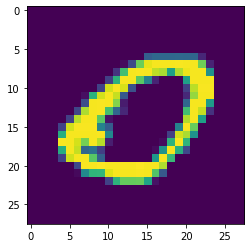

In [36]:
imageshow(chitro,lekha)

In [37]:
chitro.shape

torch.Size([28, 28])

In [38]:
batch = 128
test_dataset = ImageFolder('mnist_png/testing',transform=transform)
len(test_dataset)

10000

In [39]:
val,test = torch.utils.data.random_split(test_dataset, [5000,5000])
len(val), len(test)

(5000, 5000)

In [40]:
train_dl = DataLoader(train_dataset,batch,shuffle=True,num_workers=4)
val_ds = DataLoader(val,batch*2,num_workers=4,shuffle = False)


In [41]:
test_ds = DataLoader(val,batch*2,num_workers=4,shuffle = False)

(469,20) respectively are the number of batches of `train_dl` and `val_ds` 

In [17]:
469*128

60032

In [18]:
outDimension = lambda i,k,p=0,s=1: np.floor((i+2*p-k)/s) +1

outDimension(12,5)

8.0

In [26]:
class Netto(nn.Module):
    def __init__(self):
        super(Netto, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # Image size 32 x32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) # Image size 16 x16
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2) # Image size 8 x8 = 64
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x2 = self.relu4(x)
        x = self.fc3(x2) 
        return x

In [27]:
model = Netto().to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [28]:
from tqdm.notebook import tqdm

In [29]:
train_accu=[]
train_losses = []
def train(model,epoch, optimizer,loss,trainLoader):
    print(f'Epoch: {epoch}')
    model.train()
    running_loss =0
    correct = 0
    total =0
    for data in tqdm(trainLoader):
        
        image,label = data[0].to(device),data[1].to(device)
        optimizer.zero_grad()
        out = model(image)
        loss_ = loss(out,label)
        loss_.backward()
        optimizer.step()

        running_loss+=loss_.item()
        _,predicted = out.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
    
    train_loss = running_loss/len(trainLoader)
    acc = 100.*correct/total

    train_accu.append(acc)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,acc))


In [30]:
eval_losses=[]
eval_accu=[]

def testing(model,epoch,testloader,loss):
    model.eval()
    running_loss=0
    correct=0
    total=0 
    with torch.no_grad():
        for data in tqdm(testloader):
            images,labels = data[0].to(device),data[1].to(device)

            out = model(images)

            loss_ = loss(out,labels)
            running_loss+=loss_.item()
            _,predicted = out.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()

    test_loss=running_loss/len(testloader)
    accu=100.*correct/total
 
    eval_losses.append(test_loss)
    eval_accu.append(accu)
 
    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))



In [42]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
for i in range(5):
    train(model,i,optimizer,loss_fn,train_dl)
    testing(model,i,val_ds,loss_fn)

Epoch: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 2.295 | Accuracy: 16.120


  0%|          | 0/20 [00:00<?, ?it/s]

Test Loss: 2.282 | Accuracy: 21.520
Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 2.210 | Accuracy: 30.688


  0%|          | 0/20 [00:00<?, ?it/s]

Test Loss: 1.911 | Accuracy: 42.380
Epoch: 2


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.893 | Accuracy: 75.085


  0%|          | 0/20 [00:00<?, ?it/s]

Test Loss: 0.421 | Accuracy: 87.440
Epoch: 3


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.349 | Accuracy: 89.540


  0%|          | 0/20 [00:00<?, ?it/s]

Test Loss: 0.265 | Accuracy: 92.120
Epoch: 4


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss: 0.252 | Accuracy: 92.382


  0%|          | 0/20 [00:00<?, ?it/s]

Test Loss: 0.193 | Accuracy: 94.400


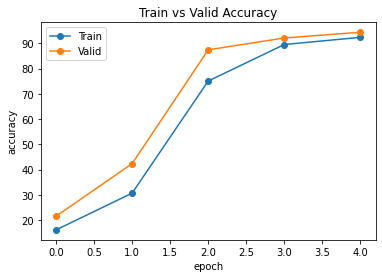

In [43]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

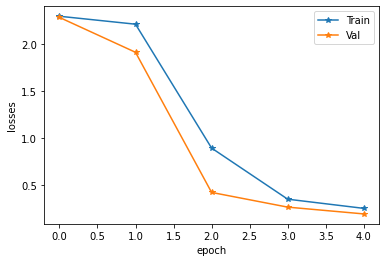

In [44]:
plt.plot(train_losses,'-*')
plt.plot(eval_losses,'-*')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Val'])
plt.show()

In [45]:
torch.save(model.state_dict(),'Newmnist.pth')

In [54]:
chitro.shape

torch.Size([1, 28, 28])

In [55]:
chitro=chitro.unsqueeze(0)
chitro.shape

torch.Size([1, 1, 28, 28])

In [63]:
chitro = chitro.to('cuda')

In [64]:
type(chitro), chitro.device

(torch.Tensor, device(type='cuda', index=0))

In [65]:
OUT = model(chitro)

In [66]:
OUT

tensor([[ 8.2122, -8.5033,  5.4528, -2.4113, -8.0649,  3.8785,  3.7161, -7.2734,
          3.4689, -4.1821]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [67]:
print(OUT.max())

tensor(8.2122, device='cuda:0', grad_fn=<MaxBackward1>)


In [76]:
val, indx = OUT.max(1)
val.item(),indx.item()

(8.212194442749023, 0)

Label: 0 | 0


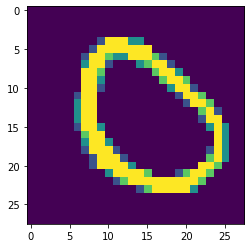

In [72]:
poop = chitro.to('cpu')
imageshow(poop.squeeze(),lekha)

In [77]:
all_class[indx.item()]

'0'

In [78]:
chitro2 , ground = test_dataset[987]
print(chitro2.shape,ground)

torch.Size([1, 28, 28]) 1


In [ ]:
chitro2 = chitro2.unsqueeze(0)
chitro2_pred = model(chitro2)
